In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Image show

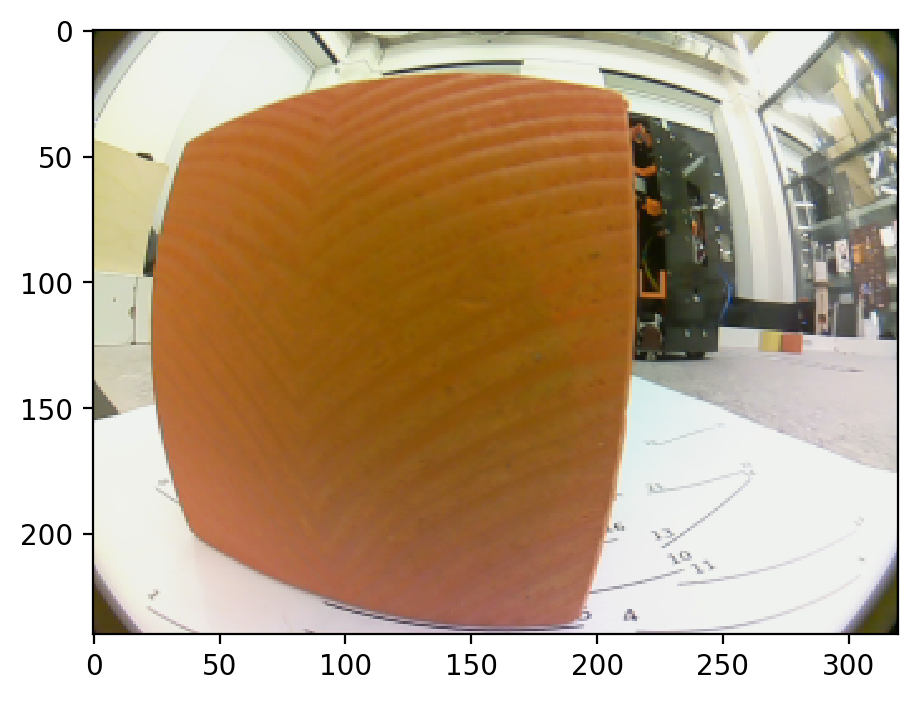

In [4]:
raw_img = cv2.cvtColor(cv2.imread("imgs/1_5.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(raw_img);

# Undistorte image

In [8]:
K=np.array([[543.107811968841, 0.0, 630.7227631662455], [0.0, 540.0320855865099, 486.5749791589516], [0.0, 0.0, 1.0]])
D=np.array([[-0.05195582161040964], [-0.009477421485536482], [0.010893416415594874], [-0.005379345567357744]])

In [ ]:
field_img = cv2.fisheye.undistortImage(img, K, D, Knew = K_new)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(cv2.cvtColor(field_img, cv2.COLOR_RGB2BGR))